In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
# from torch.utils.tensorboard import SummaryWriter

from PIL import Image
from skimage.color import rgba2rgb
import cv2
from IPython.display import display, clear_output
from math import *
import time

from os import makedirs, path
from copy import deepcopy

from tqdm import tqdm

from NCA import CA, totalistic
import pygame, pygame_gui

pygame 2.0.1 (SDL 2.0.14, Python 3.9.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def LMB_make(state, r=5, s=1):
    '''
    left click to make
    r: radius of brush
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = torch.exp(-rm**2 / s**2)
    blur = torch.where(rm <= 1., blur, 0.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, :, i, j] = state[:, :, i, j] + blur[count_i, count_j]
    return state
    
    
def RMB_del(state, r=5, s=1):
    '''
    right click to erase
    r: radius of eraser
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = (1 - torch.exp(-rm**2 / s**2))
    blur = torch.where(rm <= 1., blur, 1.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, :, i, j] = state[:, :, i, j] * blur[count_i, count_j]
    return state

def WHEEL_permute(cdim_order, direction):
    cdim_order = np.mod(np.add(cdim_order, direction), CHANNELS)
    
    return cdim_order
    

# Test

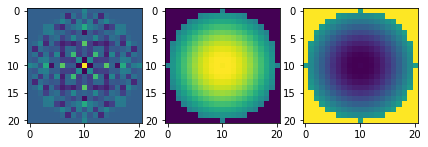

In [3]:
CHANNELS=16 # number of channels in grid
FILTERS=64 # number of filters per channel
HIDDEN=256 # number of hidden neurons

RADIUS=10 # radius if kernel
KCENTER=0.1 # radius of gaussian ring
KSMOOTH=1. # gaussian smoothing
OUTR=1. # outer ring of kernel
INR=0.  # inner ring of kernel
GAMP=-0.1 # growth kernel amplitude


ca = CA(CHANNELS=CHANNELS, FILTERS=FILTERS, HIDDEN=HIDDEN,
        RADIUS=RADIUS, KCENTER=KCENTER, KSMOOTH=KSMOOTH, OUTR=OUTR, INR=INR, GAMP=GAMP).cuda() 


fig, ax = plt.subplots(1, 3, figsize=(7, 2.5))
ax[0].imshow(totalistic(ca.rule.filter1 * ca.rule.decay_kernel)[0, 0, :, :].cpu().detach().numpy())
ax[1].imshow(ca.rule.decay_kernel.cpu().detach().numpy())
ax[2].imshow(ca.rule.growth_kernel.cpu().detach().numpy())

In [17]:
ca.rule.filter2

Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), padding_mode=circular)

In [4]:
# brush properties
r = 40
s = 1

In [5]:
# resolution of grid
RESX=350
RESY=200

# pygame stuff
######################################
pygame.init()
size = RESX, RESY
# screen = pygame.display.set_mode(size)
screen = pygame.Surface(size)
UPSCALE = 3
RESXup, RESYup = int(RESX*UPSCALE), int(RESY*UPSCALE)
upscaled_screen = pygame.display.set_mode([RESXup, RESYup])

running = True
time_ticking = True
LMB_trigger = False
RMB_trigger = False
WHEEL_trigger = False
cdim_order = np.arange(0, CHANNELS)

clock = pygame.time.Clock()
font = pygame.font.SysFont("Noto Sans", 12)
def update_fps(clock, font):
    fps = str(int(clock.get_fps()))
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf
######################################

# CENTER SEED
seed = torch.cuda.FloatTensor(np.zeros((CHANNELS, RESX, RESY))).unsqueeze(0)
seed[:, 3:, RESX//2, RESY//2] = 1
state = seed.clone()

# inject noise
signal_injection = torch.zeros(size=state.shape)
noise_amp = 1.
noise_idx = slice(4, 10)

update_rate = 1.
ticker = 0.
sink = False

with torch.no_grad():
    while running:              
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                
            if event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    LMB_trigger = True
                if event.button == 3:
                    RMB_trigger = True
            if event.type == pygame.MOUSEBUTTONUP:
                if event.button == 1:
                    LMB_trigger = False
                if event.button == 3:
                    RMB_trigger = False
                    
            if event.type == pygame.MOUSEWHEEL:
                WHEEL_trigger = True
                direction = event.y
                
            if event.type== pygame.KEYDOWN and event.key == pygame.K_LEFTBRACKET:
                update_rate += -0.5
            if event.type== pygame.KEYDOWN and event.key == pygame.K_RIGHTBRACKET:
                update_rate += 0.5
            
            if event.type == pygame.MOUSEBUTTONUP and event.button == 2:
                # scroll through channel dims
                cdim_order = np.arange(0, state.shape[1])
                    
            if event.type == pygame.KEYDOWN and event.key == pygame.K_SPACE:
                # pick another random CA
                ca = CA(CHANNELS=CHANNELS, FILTERS=FILTERS, HIDDEN=HIDDEN,
                        RADIUS=RADIUS, KCENTER=KCENTER, KSMOOTH=KSMOOTH, OUTR=OUTR, INR=INR, GAMP=GAMP).cuda() 
                
                
#             if event.type == pygame.VIDEORESIZE:
#                 print(event.w, event.h)
#                 surface = pygame.display.set_mode((event.w, event.h),
#                                               pygame.RESIZABLE)
            if event.type== pygame.KEYDOWN and event.key == pygame.K_t:
                ca.rule.totalistic = not ca.rule.totalistic
            if event.type== pygame.KEYDOWN and event.key == pygame.K_g:
                ca.rule.use_growth_kernel = not ca.rule.use_growth_kernel
            if event.type== pygame.KEYDOWN and event.key == pygame.K_s:
                sink = not sink
            if event.type== pygame.KEYDOWN and event.key == pygame.K_p:
                # pause/toggle time
                time_ticking = not time_ticking
                
            if event.type== pygame.KEYDOWN and event.key == pygame.K_r:
                # start from seed 
                state = seed.clone()
                

        mouse_pos = pygame.mouse.get_pos()
        if LMB_trigger:
            state = LMB_make(state, r=r, s=s)
        if RMB_trigger:
            state = RMB_del(state, r=r, s=s)
        
        
        # scroll to permute through which channels get visualized
        if WHEEL_trigger:
            cdim_order = WHEEL_permute(cdim_order, direction)
            WHEEL_trigger = False
            
        nx = state.cpu()[:, cdim_order].numpy()[0, 0:3, :, :].transpose(1, 2, 0)
#         nx = np.clip(nx, 0, 1)*255
        nx = nx + 128
#         nx = (nx + 1)/2 * 255
#         nx = nx.astype(np.uint8)
        if time_ticking:
#             state = ca.forward_perception(state, dt=1)
#             state = ca.forward_masked(state)
            state = ca.forward(state, update_rate=update_rate)
            ticker += 1
    
        if sink:
            state[:, :, 0*RESX//10:10*RESX//10, 4*RESY//10:6*RESY//10] = torch.cuda.FloatTensor([-127. * np.sin(ticker / 20.)])
    
#         signal_injection[:, noise_idx, :, :] = noise_amp * torch.randn(size=(signal_injection[:, noise_idx, :, :].shape))
#         signal_injection = signal_injection.to('cuda')
#         state = state + signal_injection

        pygame.surfarray.blit_array(screen, nx)        
        frame = pygame.transform.scale(screen, (RESXup, RESYup))
        upscaled_screen.blit(frame, frame.get_rect())
        upscaled_screen.blit(update_fps(clock, font), (10,0))
        pygame.display.flip()
        clock.tick(120)
        
pygame.quit()


In [6]:
torch.cuda.FloatTensor([-127. * np.sin(ticker / 10.)])

tensor([93.8759], device='cuda:0')

(array([565822.,   5757.,   5039.,   4634.,   4499.,   4552.,   4538.,
          4913.,   5616., 514630.]),
 array([-128. , -102.5,  -77. ,  -51.5,  -26. ,   -0.5,   25. ,   50.5,
          76. ,  101.5,  127. ], dtype=float32),
 <BarContainer object of 10 artists>)

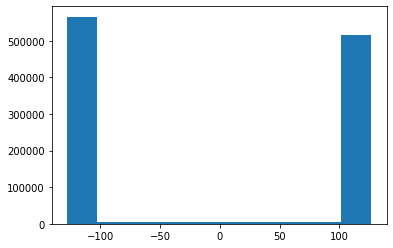

In [7]:
plt.hist(state.cpu().detach().numpy().reshape(-1))

In [8]:
torch.gather(state, 1, torch.argsort(state, dim=1)).shape

torch.Size([1, 16, 350, 200])

In [9]:
b, c, h, w = state.shape
test = torch.gather(state, 1, torch.randint(state.shape[1], size=(b, 1, h, w)).cuda())

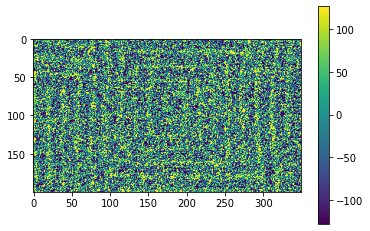

In [10]:
plt.imshow(test[0, 0].detach().cpu().numpy().transpose())
plt.colorbar()

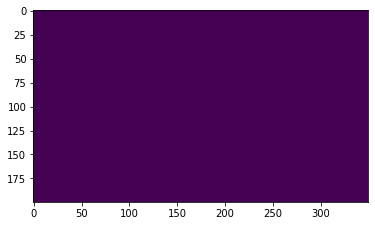

In [11]:
plt.imshow(torch.gather(state, 1, torch.argmin(state, dim=1, keepdim=True)).detach().cpu().numpy()[0, 0].transpose())

In [12]:
state.reshape(1, -1, 350*70).shape

RuntimeError: shape '[1, -1, 24500]' is invalid for input of size 1120000

In [ ]:
idxs = torch.argmin(state.reshape(1, -1, 350*70), dim=2)

In [ ]:
state.mean(dim=1).shape

In [ ]:
state[0:, :].shape

In [ ]:
state[torch.argmin(state.reshape(1, -1, 350*70), dim=2)].shape

In [ ]:
R = 20
ident = torch.zeros(2*R + 1, 2*R + 1)
ident[R, R] = 1

---

In [ ]:
from torch import  nn

In [ ]:
m = nn.Conv2d(10, 30, 5)

In [ ]:
m.weight.shape